In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json
import seaborn as sns
import re

from scipy.stats import fisher_exact
from tqdm import tqdm
from src.utils import calculate_results_row, plot_performance_frs, plot_histogram, plot_frs_histogram, plot_compensation_barplot

# make the default font size point 7
plt.rcParams.update({"font.size": 7})

%load_ext autoreload
%autoreload 2

## Load datasets

First let's load the predicted effects for mutations in *rpoB* (which is the only gene in the WHOv2 catalogue that confers resistance to RIF). This will let us identify all the definite resistance-associated variants. (If we used the WHOv2 catalogue we'd have to unpack and deal with generic rules which is harder).

In [2]:
effects = pd.read_parquet('data/cryptic_3/RIF_EFFECTS.parquet', engine='pyarrow')

resistance_mutations = effects.GENE_MUTATION.unique()
resistance_mutations = resistance_mutations.astype(str)

# Apply a mask to filter out unclear mutations (those with 'X' in them)
mask = np.char.find(resistance_mutations, 'X') == -1
resistance_mutations = resistance_mutations[mask]

print(f"There are {len(resistance_mutations)} unique resistance mutations according to WHOv2 in our dataset")

print(f"These include {resistance_mutations[:3]}")

There are 131 unique resistance mutations according to WHOv2 in our dataset
These include ['rpoB_S450L' 'rpoB_H445D' 'rpoB_D435V']


We will get our list of compensatory mutations from this paper

> Brunner V, Fowler PW
>
> Compensatory mutations are associated with increased in vitro growth in resistant clinical samples of *Mycobacterium tuberculosis*.
>
> mGen 10:001187 doi:10.1099/mgen.0.001187

The list is publicly available from here:

https://github.com/fowler-lab/tb-rnap-compensation

In [3]:
CMs = pd.read_csv('data/final_CM_hit_list.csv')
CMs = CMs[CMs.homoplasy == True]
compensatory_mutations = CMs['putative CM'].unique()

print(f"There are {len(compensatory_mutations)} compensatory mutations in the RNAP identified by this study")
print(f"These include {compensatory_mutations[:3]}")

There are 51 compensatory mutations in the RNAP identified by this study
These include ['rpoC_V483G' 'rpoC_I491V' 'rpoC_V483A']


In [4]:
# #uncomment this to remove the mutation rpoC_F452L from the compensatory mutations list
# compensatory_mutations = np.delete(compensatory_mutations, np.where(compensatory_mutations == 'rpoC_F452L'))

# compensatory_mutations

### Genetics

First let's load the dataframe of all samples that we have whole genome sequencing data

In [5]:
genomes = pd.read_parquet('data/cryptic_3/GENOMES.parquet', engine='pyarrow')
genomes.reset_index(inplace=True)
genomes.set_index('UNIQUEID', inplace = True)
genomes['HAS_GENOME'] = True
print(f"There are {len(genomes)} unique genomes in the dataset")

There are 41575 unique genomes in the dataset


Now load all the mutations in the RNA polymerase and identify which mutations are associated with resistance and which have been identified as compensatory

In [6]:
mutations = pd.read_parquet('data/cryptic_3/RNAP_MUTATIONS.parquet', engine='pyarrow')

mutations['GENE_MUTATION'] = np.where(
    mutations['IS_MINOR'],  # Condition: if IS_MINOR_ALLELE is True
    mutations['GENE'].astype(str) + '_' + mutations['MINOR_MUTATION'].astype(str),  # Then: use GENE + MINOR_MUTATION
    mutations['GENE'].astype(str) + '_' + mutations['MUTATION'].astype(str)  # Else: use GENE + MUTATION
)

mutations

,UNIQUEID,GENE,MUTATION,REF,ALT,NUCLEOTIDE_NUMBER,NUCLEOTIDE_INDEX,GENE_POSITION,CODES_PROTEIN,INDEL_LENGTH,...,AMINO_ACID_NUMBER,AMINO_ACID_SEQUENCE,NUMBER_NUCLEOTIDE_CHANGES,IS_NULL,IS_MINOR,MINOR_MUTATION,MINOR_READS,COVERAGE,FRS,GENE_MUTATION
1637,site.02.subj.0069.lab.22A019.iso.1,rpoB,S450L,tcg,ttg,NaN,NaN,450.0,True,NaN,...,450.0,L,1.0,False,False,None,NaN,64.0,1.0,rpoB_S450L
1638,site.02.subj.0069.lab.22A019.iso.1,rpoB,A1075A,gct,gcc,NaN,NaN,1075.0,True,NaN,...,1075.0,A,1.0,False,False,None,NaN,114.0,1.0,rpoB_A1075A
1639,site.02.subj.0069.lab.22A019.iso.1,rpoC,V483A,gtg,gcg,NaN,NaN,483.0,True,NaN,...,483.0,A,1.0,False,False,None,NaN,108.0,1.0,rpoC_V483A
4017,site.ENA.subj.SAMEA2533644.lab.1.iso.1,rpoB,A1075A,gct,gcc,NaN,NaN,1075.0,True,NaN,...,1075.0,A,1.0,False,False,None,NaN,104.0,1.0,rpoB_A1075A
4018,site.ENA.subj.SAMEA2533644.lab.1.iso.1,rpoC,A172V,gcc,gtc,NaN,NaN,172.0,True,NaN,...,172.0,V,1.0,False,False,None,NaN,102.0,1.0,rpoC_A172V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61559110,site.10.subj.YA00084833.lab.YA00084833.iso.1,rpoB,G876G,ggt,ggg,NaN,NaN,876.0,True,NaN,...,876.0,G,1.0,False,False,None,NaN,120.0,1.0,rpoB_G876G
61559111,site.10.subj.YA00084833.lab.YA00084833.iso.1,rpoB,A1075A,gct,gcc,NaN,NaN,1075.0,True,NaN,...,1075.0,A,1.0,False,False,None,NaN,109.0,1.0,rpoB_A1075A
61559112,site.10.subj.YA00084833.lab.YA00084833.iso.1,rpoC,A861S,gcg,tcg,NaN,NaN,861.0,True,NaN,...,861.0,S,1.0,False,False,None,NaN,126.0,1.0,rpoC_A861S
61560265,site.07.subj.FD_127_4242.lab.12_0613161.iso.1,rpoB,T361T,acc,act,NaN,NaN,361.0,True,NaN,...,361.0,T,1.0,False,False,None,NaN,75.0,1.0,rpoB_T361T


In [7]:
mutations['IS_RESISTANT_MUTATION'] = mutations['GENE_MUTATION'].isin(resistance_mutations)
mutations['IS_COMPENSATORY_MUTATION'] = mutations['GENE_MUTATION'].isin(compensatory_mutations)
mutations.set_index('UNIQUEID', inplace=True)

print(f"There are {len(mutations)} RNAP mutations in {len(mutations.index.unique())} samples that have been whole genome sequenced in our dataset")

rpoB = mutations[mutations.GENE == 'rpoB']

print(f"{rpoB[~rpoB.IS_MINOR].index.nunique()} samples contain one or more of {len(rpoB[~rpoB.IS_MINOR])} mutations in rpoB supported by an FRS ≥ 0.90")
print(f"{rpoB[rpoB.IS_MINOR].index.nunique()} samples contain one or more of {len(rpoB[rpoB.IS_MINOR])} mutations in rpoB supported by an FRS < 0.90")
mutations[:3]

There are 101020 RNAP mutations in 37594 samples that have been whole genome sequenced in our dataset
31347 samples contain one or more of 58789 mutations in rpoB supported by an FRS ≥ 0.90
1372 samples contain one or more of 1940 mutations in rpoB supported by an FRS < 0.90


,GENE,MUTATION,REF,ALT,NUCLEOTIDE_NUMBER,NUCLEOTIDE_INDEX,GENE_POSITION,CODES_PROTEIN,INDEL_LENGTH,INDEL_NUCLEOTIDES,...,NUMBER_NUCLEOTIDE_CHANGES,IS_NULL,IS_MINOR,MINOR_MUTATION,MINOR_READS,COVERAGE,FRS,GENE_MUTATION,IS_RESISTANT_MUTATION,IS_COMPENSATORY_MUTATION
UNIQUEID,,,,,,,,,,,,,,,,,,,,,
site.02.subj.0069.lab.22A019.iso.1,rpoB,S450L,tcg,ttg,NaN,NaN,450.0,True,NaN,None,...,1.0,False,False,None,NaN,64.0,1.0,rpoB_S450L,True,False
site.02.subj.0069.lab.22A019.iso.1,rpoB,A1075A,gct,gcc,NaN,NaN,1075.0,True,NaN,None,...,1.0,False,False,None,NaN,114.0,1.0,rpoB_A1075A,False,False
site.02.subj.0069.lab.22A019.iso.1,rpoC,V483A,gtg,gcg,NaN,NaN,483.0,True,NaN,None,...,1.0,False,False,None,NaN,108.0,1.0,rpoC_V483A,False,True


### Drug susceptibility measurements

Let's load in the DTS data; one problem we will have to solve is that some samples have more than one rifampicin measurement. For example, they could have an MIC from a UKMYC6 96-well broth microdilution plate but they could also have an R/S from a MGIT960 tube. The approach we will take is to classify any samples as resistant if any of their DST results indicate resistance and we will keep, by preference, the UKMYC measurements since we have more detailed information on these.

In [8]:
phenotypes = pd.read_pickle('data/cryptic_3/DST_MEASUREMENTS.pkl.gz')
phenotypes.reset_index(inplace=True)
phenotypes = phenotypes[phenotypes.DRUG == 'RIF']
phenotypes['HAS_DST'] = True

agg_phenotypes = phenotypes[['UNIQUEID', 'DRUG']].groupby(['UNIQUEID']).count()
agg_phenotypes.value_counts(dropna=False)

multiples = agg_phenotypes[agg_phenotypes.DRUG>1].index
singles = agg_phenotypes[agg_phenotypes.DRUG==1].index

print(f"There are {len(singles) + len(multiples)} samples with at least one RIF DST measurement.")
print(f"Of these {len(singles)} samples have a single DST measurement and {len(multiples)} have multiple DST measurements.")

phenotypes.set_index('UNIQUEID', inplace = True)
phenotypes[:3]

There are 52148 samples with at least one RIF DST measurement.
Of these 43150 samples have a single DST measurement and 8998 have multiple DST measurements.


,DRUG,SOURCE,METHOD_1,METHOD_2,METHOD_3,METHOD_CC,METHOD_MIC,PHENOTYPE,QUALITY,HAS_DST
UNIQUEID,,,,,,,,,,
site.24.subj.PT-2.lab.1997-606.iso.1,RIF,SEQTREAT2020,liquid media,MGIT,BACTEC460,1.0,NaN,S,MEDIUM,True
site.24.subj.PT-4.lab.1998-151.iso.1,RIF,SEQTREAT2020,liquid media,MGIT,BACTEC460,1.0,NaN,S,MEDIUM,True
site.24.subj.PT-5.lab.1998-713.iso.1,RIF,SEQTREAT2020,liquid media,MGIT,BACTEC460,1.0,NaN,S,MEDIUM,True


In [9]:
phenotypes.METHOD_2.value_counts()

METHOD_2
microdilution plate    24172
MGIT                   23682
LJ                      7266
                        3030
middlebrook             1563
Name: count, dtype: int64

In [10]:
# go through the list of UNIQUEIDs with multiple RIF DST measurements and apply the logic described above

table = []
for uid in tqdm(multiples):

    phenotype=None
    first_row=True
    for idx,row in phenotypes.loc[uid].iterrows():

        # if this is the first entry, just add it
        if first_row:

            table.append(row)
            phenotype=row.PHENOTYPE
            method=row.METHOD_3
            first_row=False

        else:   

            # but if the new phenotype is resistant, add the row
            if phenotype=='S' and row.PHENOTYPE == 'R':
                table[-1] = row

            # or replace with the UKMYC result if the phenotypes are the same 
            elif phenotype==row.PHENOTYPE and row.METHOD_3 in ['UKMYC5', 'UKMYC6']:
                table[-1] = row

phenotypes = pd.concat([phenotypes.loc[singles], pd.DataFrame(table)])
assert phenotypes.index.duplicated().sum()==0, 'there are still duplicates in the table'
phenotypes.index.name = 'UNIQUEID'
phenotypes = phenotypes[phenotypes.PHENOTYPE.isin(['S', 'R'])]
print(f"We have {len(phenotypes)} samples with a definite (R/S) DST measurement for RIF")

phenotypes = phenotypes[phenotypes.QUALITY!='LOW']
print(f"Removing samples where there is disagreement about the phenotype leaves {len(phenotypes)} samples")

phenotypes[:3]

100%|██████████| 8998/8998 [00:06<00:00, 1382.85it/s]


We have 51183 samples with a definite (R/S) DST measurement for RIF
Removing samples where there is disagreement about the phenotype leaves 48031 samples


,DRUG,SOURCE,METHOD_1,METHOD_2,METHOD_3,METHOD_CC,METHOD_MIC,PHENOTYPE,QUALITY,HAS_DST
UNIQUEID,,,,,,,,,,
site.00.subj.1000347.lab.H111540004.iso.1,RIF,NEJM2018,solid media,LJ,resistance ratio,,NaN,R,MEDIUM,True
site.00.subj.1000595.lab.H123460044.iso.1,RIF,NEJM2018,solid media,LJ,resistance ratio,,NaN,R,MEDIUM,True
site.00.subj.1004213.lab.H111060034.iso.1,RIF,NEJM2018,solid media,LJ,resistance ratio,,NaN,R,MEDIUM,True


### Merging

Now we can join the two sets of samples to identify those which have both WGS and DST data, which should be all of them.

In [11]:
samples = genomes[['HAS_GENOME']].join(phenotypes[['HAS_DST','PHENOTYPE']], how='left')
samples.HAS_DST = samples.HAS_DST.fillna(False)
print(f"We have {(samples.HAS_DST).sum()} samples with both WGS data and a definite DST measurement for RIF")
samples[:3]

We have 35538 samples with both WGS data and a definite DST measurement for RIF


/var/folders/84/9nb2gsqj4hlcxztvwf19wg680000gq/T/ipykernel_69576/1676315562.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  samples.HAS_DST = samples.HAS_DST.fillna(False)


,HAS_GENOME,HAS_DST,PHENOTYPE
UNIQUEID,,,
site.10.subj.YA00019967.lab.YA00019967.iso.1,True,True,R
site.ENA.subj.SAMEA1019012.lab.1.iso.1,True,True,S
site.04.subj.06941.lab.932089.iso.1,True,True,R


In [12]:
# aggregate mutations by UNIQUEID and keep columns of interest: define FRS to be the maximum of any resistant mutations, otherwise the maximum of the remaining mutations

def aggregate_minor_major_allele(group):

    resistant_frs_value = None
    compensatory_frs_value = None

    # Check if any row has both IS_MINOR_ALLELE and RESISTANT_MUTATION    
    resistant_minor_allele_flag = any((group['IS_MINOR']) & (group['IS_RESISTANT_MUTATION']))

    # Check if any row both isn't IS_MINOR_ALLELE and RESISTANT_MUTATION
    resistant_major_allele_flag = any((~group['IS_MINOR']) & (group['IS_RESISTANT_MUTATION']))

    # Get the rows where there is a resistant major allele
    resistant_major_allele_rows = group[(~group['IS_MINOR']) & (group['IS_RESISTANT_MUTATION'])]

    # Get the rows where there is a resistant minor allele
    resistant_minor_allele_rows = group[(group['IS_MINOR']) & (group['IS_RESISTANT_MUTATION'])]
    
    if resistant_major_allele_rows.empty:

        if not resistant_minor_allele_rows.empty:

            # If there are resistant minor alleles, get the maximum FRS value for those rows
            resistant_frs_value = resistant_minor_allele_rows['FRS'].max()

    else:

        resistant_frs_value = resistant_major_allele_rows['FRS'].max()

    # Check if any row has both IS_MINOR_ALLELE and COMPENSATORY_MUTATION    
    compensatory_minor_allele_flag = any((group['IS_MINOR']) & (group['IS_COMPENSATORY_MUTATION']))

    # Check if any row both isn't IS_MINOR_ALLELE and COMPENSATORY_MUTATION
    compensatory_major_allele_flag = any((~group['IS_MINOR']) & (group['IS_COMPENSATORY_MUTATION']))

    # Get the rows where there is a resistant major allele
    compensatory_major_allele_rows = group[(~group['IS_MINOR']) & (group['IS_COMPENSATORY_MUTATION'])]

    # Get the rows where there is a resistant minor allele
    compensatory_minor_allele_rows = group[(group['IS_MINOR']) & (group['IS_COMPENSATORY_MUTATION'])]
    
    if compensatory_major_allele_rows.empty:

        if not compensatory_minor_allele_rows.empty:

            # If there are resistant minor alleles, get the maximum FRS value for those rows
            compensatory_frs_value = compensatory_minor_allele_rows['FRS'].max()

    else:

        compensatory_frs_value = compensatory_major_allele_rows['FRS'].max()

    return pd.Series({
        'HAS_RNAP_MUTATIONS': True,
        'HAS_RESISTANT_MUTATION': group['IS_RESISTANT_MUTATION'].max(),
        'N_RAV': group['IS_RESISTANT_MUTATION'].sum(),
        'HAS_MINOR_RAV': resistant_minor_allele_flag,
        'HAS_MAJOR_RAV': resistant_major_allele_flag,
        'MAX_RAV_FRS': resistant_frs_value,  # Use the maximum FRS for any RAVs present
        'HAS_COMPENSATORY_MUTATION': group['IS_COMPENSATORY_MUTATION'].max(),
        'N_CM': group['IS_COMPENSATORY_MUTATION'].sum(),
        'HAS_MINOR_CM': compensatory_minor_allele_flag,
        'HAS_MAJOR_CM': compensatory_major_allele_flag,
        'MAX_CM_FRS': compensatory_frs_value,  # Use the maximum FRS for any compensatory mutations present
    })

# Apply the custom aggregation function
agg_mutations = mutations.groupby('UNIQUEID').apply(aggregate_minor_major_allele).reset_index()
agg_mutations.set_index('UNIQUEID', inplace=True)
agg_mutations[:3]

,HAS_RNAP_MUTATIONS,HAS_RESISTANT_MUTATION,N_RAV,HAS_MINOR_RAV,HAS_MAJOR_RAV,MAX_RAV_FRS,HAS_COMPENSATORY_MUTATION,N_CM,HAS_MINOR_CM,HAS_MAJOR_CM,MAX_CM_FRS
UNIQUEID,,,,,,,,,,,
site.00.subj.1000347.lab.H111540004.iso.1,True,True,1,False,True,1.0,False,0,False,False,NaN
site.00.subj.1000595.lab.H123460044.iso.1,True,True,1,False,True,1.0,True,1,False,True,1.0
site.00.subj.1004213.lab.H111060034.iso.1,True,True,1,False,True,1.0,True,1,False,True,1.0


Now we can join the information on the samples which have RNAP mutations to the table of samples with a DST result and a whole genome. We will need to fill in the gaps for those samples which do not have any RNAP mutations.

In [13]:
samples = samples.join(agg_mutations, how='left')

samples['IS_RESISTANT'] = samples.PHENOTYPE == 'R'

# because we did a left join and hence there were a lot of NaNs to fill in, we need to force these columns to be boolean
for i in ['HAS_RNAP_MUTATIONS', 'HAS_RESISTANT_MUTATION', 'HAS_MINOR_RAV', 'HAS_MAJOR_RAV', 'HAS_COMPENSATORY_MUTATION', 'HAS_MINOR_CM', 'HAS_MAJOR_CM']:
    samples[i] = samples[i].fillna(False)    
    samples[i] = samples[i].astype(bool)

samples[:3]

/var/folders/84/9nb2gsqj4hlcxztvwf19wg680000gq/T/ipykernel_69576/2861957674.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  samples[i] = samples[i].fillna(False)
/var/folders/84/9nb2gsqj4hlcxztvwf19wg680000gq/T/ipykernel_69576/2861957674.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  samples[i] = samples[i].fillna(False)
/var/folders/84/9nb2gsqj4hlcxztvwf19wg680000gq/T/ipykernel_69576/2861957674.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_obj

,HAS_GENOME,HAS_DST,PHENOTYPE,HAS_RNAP_MUTATIONS,HAS_RESISTANT_MUTATION,N_RAV,HAS_MINOR_RAV,HAS_MAJOR_RAV,MAX_RAV_FRS,HAS_COMPENSATORY_MUTATION,N_CM,HAS_MINOR_CM,HAS_MAJOR_CM,MAX_CM_FRS,IS_RESISTANT
UNIQUEID,,,,,,,,,,,,,,,
site.10.subj.YA00019967.lab.YA00019967.iso.1,True,True,R,True,True,1.0,False,True,1.0,True,1.0,False,True,1.000000,True
site.ENA.subj.SAMEA1019012.lab.1.iso.1,True,True,S,True,False,0.0,False,False,NaN,True,1.0,True,False,0.285714,False
site.04.subj.06941.lab.932089.iso.1,True,True,R,True,True,1.0,False,True,1.0,True,1.0,False,True,1.000000,True


In [14]:
print(f"As you might expect nearly all of the samples with no RNAP mutations test as susceptible to RIF:")

samples_with_dst = copy.deepcopy(samples[(samples.HAS_DST) & (samples.HAS_GENOME)])
print(pd.crosstab(samples_with_dst.HAS_RNAP_MUTATIONS, samples_with_dst.IS_RESISTANT))

As you might expect nearly all of the samples with no RNAP mutations test as susceptible to RIF:
IS_RESISTANT        False  True 
HAS_RNAP_MUTATIONS              
False                3563     49
True                21565  10361


In [15]:
print(f"There are {samples_with_dst.HAS_RESISTANT_MUTATION.sum()} samples with a RIF resistance-conferring mutation in the RNAP and RIF DST, at any level of read support")

print(f"Of these {(samples_with_dst.HAS_MAJOR_RAV & ~samples_with_dst.HAS_MINOR_RAV).sum()} samples only have ≥1 homogeneous RAVs whilst {(~samples_with_dst.HAS_MAJOR_RAV & samples_with_dst.HAS_MINOR_RAV).sum()} have ≥1 minor RAVs and {(samples_with_dst.HAS_MAJOR_RAV & samples_with_dst.HAS_MINOR_RAV).sum()} have ≥1 of both")

There are 10568 samples with a RIF resistance-conferring mutation in the RNAP and RIF DST, at any level of read support
Of these 10287 samples only have ≥1 homogeneous RAVs whilst 261 have ≥1 minor RAVs and 20 have ≥1 of both


Here minor RAV/ heterogeneous sample means any variant/ sample with less than 0.90 read support; so what is the distribution of the FRS?

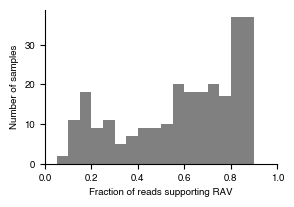

In [16]:
variant_count_all = samples_with_dst[(~samples_with_dst.HAS_MAJOR_RAV) & (samples_with_dst.HAS_MINOR_RAV) & (samples_with_dst.MAX_RAV_FRS<1) & (samples_with_dst.MAX_RAV_FRS>=0.05)]
plot_frs_histogram(variant_count_all, savefig=True)

In [17]:
print("There are", variant_count_all.shape[0], "samples with a minor RAV and no major RAVs, and 0.05<= FRS < 0.9")

There are 258 samples with a minor RAV and no major RAVs, and 0.05<= FRS < 0.9


## Influence of FRS threshold on rifampicin resistance prediction

Let's therefore change the definition of what is a resistance associated variant by altering the FRS which leads to it being classified and therefore predicting resistance.

We will store the results in a `pandas.DataFrame` so we can later plot graphs etc.

In [18]:
for i in range(5, 100, 5):
    cutoff = i / 100
    df = samples_with_dst.copy() 
    df['HAS_RESISTANT_MUTATION'] = ((df['MAX_RAV_FRS'] >= cutoff) & (df.HAS_MINOR_RAV)) | (df.HAS_MAJOR_RAV)
    a = calculate_results_row(df, description='scan FRS', min_FRS=cutoff)
    if i == 5:
        results_table = pd.DataFrame(a).T
    else:
        results_table = pd.concat([results_table,pd.DataFrame(a).T])

results_table

,description,min_FRS,TP,FP,P,TN,FN,N,sensitivity,specificity,PPV,NPV,sensitivity_error,specificity_error,PPV_error,NPV_error
0,scan FRS,0.05,10036,529,10410,24599,374,25128,0.964073,0.978948,0.949929,0.985024,0.001775,0.003575,0.004159,0.001506
0,scan FRS,0.1,10035,528,10410,24600,375,25128,0.963977,0.978988,0.950014,0.984985,0.001773,0.00358,0.004156,0.001508
0,scan FRS,0.15,10028,526,10410,24602,382,25128,0.963305,0.979067,0.950161,0.98471,0.00177,0.003612,0.004152,0.001522
0,scan FRS,0.2,10020,514,10410,24614,390,25128,0.962536,0.979545,0.951206,0.984402,0.00175,0.003648,0.004114,0.001536
0,scan FRS,0.25,10013,512,10410,24616,397,25128,0.961864,0.979624,0.951354,0.984128,0.001747,0.003679,0.00411,0.001549
0,scan FRS,0.3,10006,508,10410,24620,404,25128,0.961191,0.979784,0.951683,0.983855,0.00174,0.00371,0.004099,0.001562
0,scan FRS,0.35,10003,506,10410,24622,407,25128,0.960903,0.979863,0.951851,0.983739,0.001737,0.003723,0.004093,0.001567
0,scan FRS,0.4,10000,502,10410,24626,410,25128,0.960615,0.980022,0.9522,0.983624,0.00173,0.003736,0.00408,0.001572
0,scan FRS,0.45,9991,502,10410,24626,419,25128,0.95975,0.980022,0.952159,0.98327,0.00173,0.003776,0.004084,0.001588
0,scan FRS,0.5,9982,502,10410,24626,428,25128,0.958886,0.980022,0.952118,0.982917,0.00173,0.003814,0.004087,0.001605


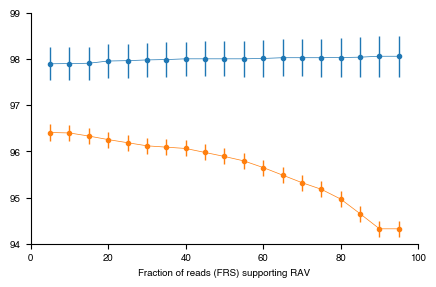

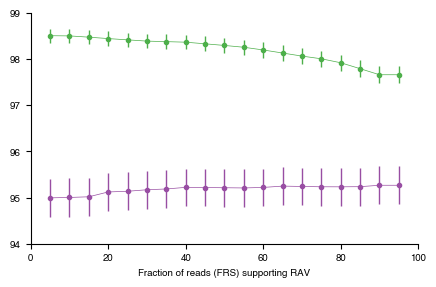

In [19]:
# plot the performance as we alter the minimum FRS
df = results_table.copy()
df = df[df.description=='scan FRS']

plot_performance_frs(df, save_figure=True, metrics=['sensitivity', 'specificity'], colours=["#ff7f0e", "#1f77b4"], save_name='fig-frs-sensitivity-specificity')
plot_performance_frs(df, save_figure=True, metrics=['PPV', 'NPV'], colours=['#984ea3', '#4daf4a'], save_name='fig-frs-ppv-npv')

Quantify strength of correlation with FRS of the different metrics by performing a linear regression and evaluating the slope

Sensitivity:
Slope: -0.023125537185904217, Intercept: 0.968087365387532, R-value: -0.9545803457457126, P-value: 2.2847855986068507e-10, Std Error: 0.0017506670449635722



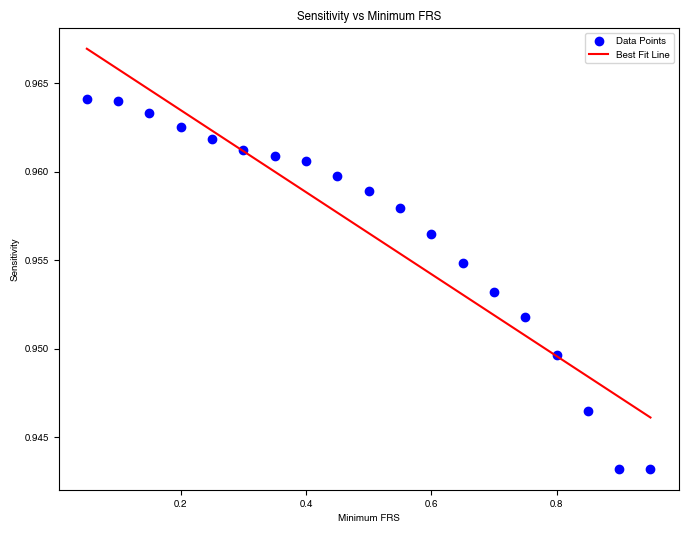

Specificity:
Slope: 0.0016700458564430768, Intercept: 0.9790930087076973, R-value: 0.9459586274755925, P-value: 9.718961848378463e-10, Std Error: 0.0001388550821317376



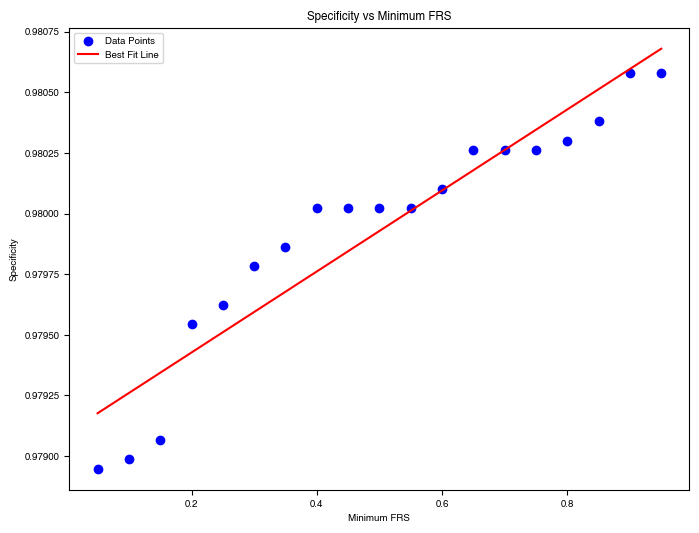

Ppv:
Slope: 0.002704196453492703, Intercept: 0.9504424357322622, R-value: 0.8733423185049517, P-value: 1.0517038628435149e-06, Std Error: 0.00036580834813638226



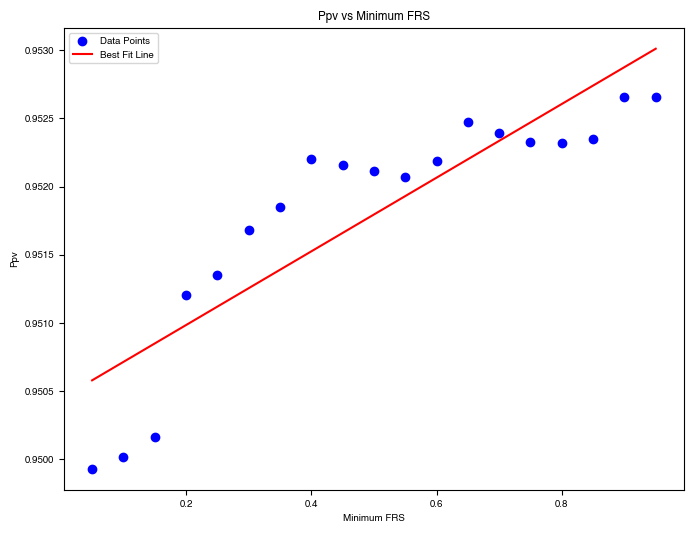

Npv:
Slope: -0.009382795932483801, Intercept: 0.9866517769639686, R-value: -0.9549225425938079, P-value: 2.145043492304085e-10, Std Error: 0.0007074310988884425



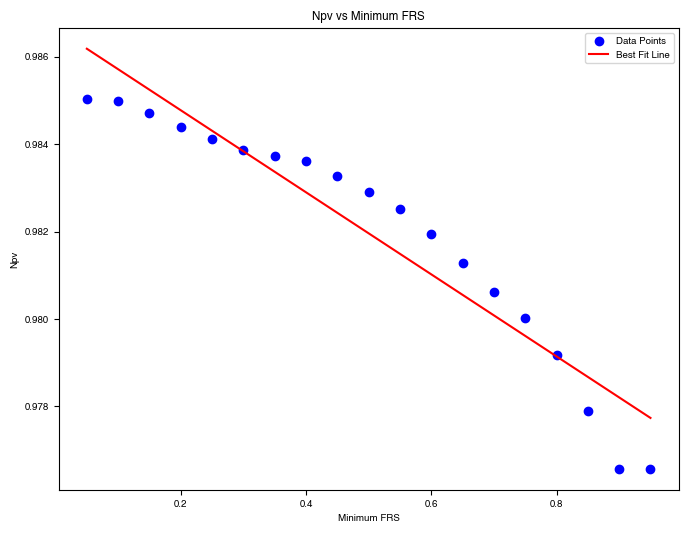

In [20]:
from scipy import stats
def plot_regression(df, metric):
    """
    Perform linear regression and plot results for the given metric.
    
    Parameters:
    df (pd.DataFrame): Dataframe containing 'min_FRS' and the specified metric.
    metric (str): The metric to analyze ('sensitivity', 'specificity', 'PPV', 'NPV').
    """
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['min_FRS'].to_list(), df[metric].to_list())
    
    print(f"{metric.capitalize()}:")
    print(f"Slope: {slope}, Intercept: {intercept}, R-value: {r_value}, P-value: {p_value}, Std Error: {std_err}\n")
    
    plt.figure(figsize=(8, 6))
    plt.scatter(df['min_FRS'], df[metric], label='Data Points', color='blue')
    plt.plot(df['min_FRS'], slope * df['min_FRS'] + intercept, color='red', label='Best Fit Line')
    plt.xlabel('Minimum FRS')
    plt.ylabel(metric.capitalize())
    plt.title(f'{metric.capitalize()} vs Minimum FRS')
    plt.legend()
    plt.show()

def analyze_all_metrics(df):
    """
    Perform regression analysis for all four metrics and plot results.
    
    Parameters:
    df (pd.DataFrame): Dataframe containing 'min_FRS' and the four metrics.
    """
    metrics = ['sensitivity', 'specificity', 'PPV', 'NPV']
    for metric in metrics:
        plot_regression(df, metric)

analyze_all_metrics(df)

Since sensitivity appears to rise let's compare two concrete cases so we can quantify the improvement using a p-value

In [21]:
df = copy.deepcopy(samples_with_dst)
df['HAS_RESISTANT_MUTATION'] = ((df['MAX_RAV_FRS'] >= 0.05) & (df.HAS_MINOR_RAV)) | (df.HAS_MAJOR_RAV)
a = calculate_results_row(df, description='bar chart', min_FRS=0.05)
results_table = pd.concat([results_table,pd.DataFrame(a).T])

samples_major_only = samples_with_dst.copy()
samples_major_only['HAS_RESISTANT_MUTATION'] = (samples_major_only['HAS_MAJOR_RAV']) #| ((samples_major_only['MAX_RAV_FRS'] >= 0.90) & (df.HAS_MINOR_RAV)) #without this the bar and FRS scan values are different 
b = calculate_results_row(samples_major_only, description='bar chart', min_FRS=0.90)
results_table = pd.concat([results_table,pd.DataFrame(b).T])

results_table = results_table.sort_values('min_FRS', ascending=False)
results_table

,description,min_FRS,TP,FP,P,TN,FN,N,sensitivity,specificity,PPV,NPV,sensitivity_error,specificity_error,PPV_error,NPV_error
0,scan FRS,0.95,9819,488,10410,24640,591,25128,0.943228,0.980579,0.952654,0.976576,0.001706,0.004445,0.0041,0.001866
0,bar chart,0.9,9819,488,10410,24640,591,25128,0.943228,0.980579,0.952654,0.976576,0.001706,0.004445,0.0041,0.001866
0,scan FRS,0.9,9819,488,10410,24640,591,25128,0.943228,0.980579,0.952654,0.976576,0.001706,0.004445,0.0041,0.001866
0,scan FRS,0.85,9853,493,10410,24635,557,25128,0.946494,0.98038,0.952349,0.97789,0.001715,0.004323,0.004105,0.001816
0,scan FRS,0.8,9886,495,10410,24633,524,25128,0.949664,0.980301,0.952317,0.979171,0.001718,0.0042,0.004099,0.001765
0,scan FRS,0.75,9908,496,10410,24632,502,25128,0.951777,0.980261,0.952326,0.980027,0.00172,0.004115,0.004094,0.00173
0,scan FRS,0.7,9923,496,10410,24632,487,25128,0.953218,0.980261,0.952395,0.980612,0.00172,0.004057,0.004089,0.001705
0,scan FRS,0.65,9940,496,10410,24632,470,25128,0.954851,0.980261,0.952472,0.981276,0.00172,0.003989,0.004082,0.001677
0,scan FRS,0.6,9957,500,10410,24628,453,25128,0.956484,0.980102,0.952185,0.981939,0.001727,0.003919,0.00409,0.001648
0,scan FRS,0.55,9972,502,10410,24626,438,25128,0.957925,0.980022,0.952072,0.982525,0.00173,0.003857,0.004091,0.001622


sensitivity -7.153218549280425 8.476648358178581e-13


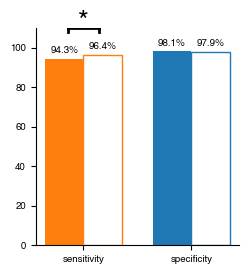

NPV -6.892489751612033 5.482424297974661e-12


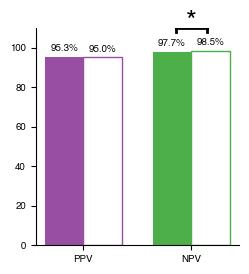

In [22]:
df = results_table[results_table.description=='bar chart']

plot_histogram(df, save_figure=True, metrics=['sensitivity', 'specificity'], colours=["#ff7f0e", "#1f77b4"], save_name='bar-sens-spec')
plot_histogram(df, save_figure=True, metrics=['PPV', 'NPV'], colours=['#984ea3', '#4daf4a'], save_name='bar-ppv-npv')

## Using compensatory mutations for resistant prediction

Now let's describe the presence/distribution of compensatory mutations in the dataset

In [23]:
print(f"Of the {len(samples_with_dst)} samples with genetics and DST there are {samples_with_dst.HAS_COMPENSATORY_MUTATION.sum()} with at least one compensatory mutation at any level of read support")

print(f"Of these {(samples_with_dst.HAS_MAJOR_CM & ~samples_with_dst.HAS_MINOR_CM).sum()} samples only have ≥1 homogeneous CM whilst {(~samples_with_dst.HAS_MAJOR_CM & samples_with_dst.HAS_MINOR_CM).sum()} only have ≥1 minor CM and {(samples_with_dst.HAS_MAJOR_CM & samples_with_dst.HAS_MINOR_CM).sum()} have ≥1 of both")

Of the 35538 samples with genetics and DST there are 4678 with at least one compensatory mutation at any level of read support
Of these 4289 samples only have ≥1 homogeneous CM whilst 384 only have ≥1 minor CM and 5 have ≥1 of both


As expected, most of the 4289 samples with at least one major CM also have a RAV (this being how the CMs were identified). A few samples have two compensatory mutations.

In [24]:
df = samples_with_dst[(samples_with_dst.HAS_MAJOR_CM & ~samples_with_dst.HAS_MINOR_CM)]
pd.crosstab(df.N_RAV, df.N_CM)

N_CM,1.0,2.0
N_RAV,,
0.0,11,0
1.0,4269,3
2.0,5,0
3.0,1,0


And most of the 384 samples that have a subpopulation containing one or more CMs are also associated with a RAV. Those that are not overhwlemingly show the CM rpoC_F452L

In [25]:
df = samples_with_dst[(~samples_with_dst.HAS_MAJOR_CM & samples_with_dst.HAS_MINOR_CM)]
pd.crosstab(df.N_RAV, df.N_CM)

N_CM,1.0,2.0,3.0,4.0
N_RAV,,,,
0.0,134,0,0,0
1.0,183,45,3,2
2.0,14,3,0,0


In [26]:
outliers = df[df.HAS_RESISTANT_MUTATION == False].index.to_list()
outliers
mutations[mutations.index.isin(outliers) & (mutations.IS_COMPENSATORY_MUTATION)].GENE_MUTATION.value_counts()

GENE_MUTATION
rpoC_F452L    132
rpoC_V483A      1
rpoC_G433S      1
Name: count, dtype: int64

In [27]:
df = copy.deepcopy(samples_with_dst)
df['HAS_RESISTANT_MUTATION'] = (df.HAS_MAJOR_RAV) | (df.HAS_MAJOR_CM)
a = calculate_results_row(df, description='with major compensatory', min_FRS=0.90)
results_table = pd.concat([results_table,pd.DataFrame(a).T])

df = copy.deepcopy(samples_with_dst)
df['HAS_RESISTANT_MUTATION'] = ((df.MAX_RAV_FRS>0.05) & (df.HAS_RESISTANT_MUTATION)) | ((df.MAX_CM_FRS>0.05) & (df.HAS_COMPENSATORY_MUTATION))
a = calculate_results_row(df, description='with minor compensatory', min_FRS=0.05)
results_table = pd.concat([results_table,pd.DataFrame(a).T])

df = copy.deepcopy(samples_with_dst)
df['HAS_RESISTANT_MUTATION'] = (df.MAX_CM_FRS>0.05) & ((df.HAS_COMPENSATORY_MUTATION))
a = calculate_results_row(df, description='minor compensatory only', min_FRS=0.05)
results_table = pd.concat([results_table,pd.DataFrame(a).T])

results_table

,description,min_FRS,TP,FP,P,TN,FN,N,sensitivity,specificity,PPV,NPV
0,scan FRS,0.95,9819,488,10410,24640,591,25128,0.943228,0.980579,0.952654,0.976576
0,bar chart,0.9,9819,488,10410,24640,591,25128,0.943228,0.980579,0.952654,0.976576
0,scan FRS,0.9,9819,488,10410,24640,591,25128,0.943228,0.980579,0.952654,0.976576
0,scan FRS,0.85,9853,493,10410,24635,557,25128,0.946494,0.98038,0.952349,0.97789
0,scan FRS,0.8,9886,495,10410,24633,524,25128,0.949664,0.980301,0.952317,0.979171
0,scan FRS,0.75,9908,496,10410,24632,502,25128,0.951777,0.980261,0.952326,0.980027
0,scan FRS,0.7,9923,496,10410,24632,487,25128,0.953218,0.980261,0.952395,0.980612
0,scan FRS,0.65,9940,496,10410,24632,470,25128,0.954851,0.980261,0.952472,0.981276
0,scan FRS,0.6,9957,500,10410,24628,453,25128,0.956484,0.980102,0.952185,0.981939
0,scan FRS,0.55,9972,502,10410,24626,438,25128,0.957925,0.980022,0.952072,0.982525


Summarise all findings on sensitivity, specificity etc in Table 1

In [28]:
table_1 = results_table 
table_1 = table_1[table_1.description != 'scan FRS']
table_1.drop(['P','N'], axis = 1, inplace = True)
table_1.to_latex(index=False,
                  float_format="{:.3f}".format)

/var/folders/_3/8y_dwngx2614_y_52fzh1c4w0000gn/T/ipykernel_49782/988324575.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_1.drop(['P','N'], axis = 1, inplace = True)


'\\begin{tabular}{llllllllll}\n\\toprule\ndescription & min_FRS & TP & FP & TN & FN & sensitivity & specificity & PPV & NPV \\\\\n\\midrule\nbar chart & 0.900 & 9819 & 488 & 24640 & 591 & 0.943 & 0.981 & 0.953 & 0.977 \\\\\nbar chart & 0.050 & 10036 & 529 & 24599 & 374 & 0.964 & 0.979 & 0.950 & 0.985 \\\\\nwith major compensatory & 0.900 & 9842 & 490 & 24638 & 568 & 0.945 & 0.980 & 0.953 & 0.977 \\\\\nwith minor compensatory & 0.050 & 10047 & 663 & 24465 & 363 & 0.965 & 0.974 & 0.938 & 0.985 \\\\\nminor compensatory only & 0.050 & 4452 & 225 & 24903 & 5958 & 0.428 & 0.991 & 0.952 & 0.807 \\\\\n\\bottomrule\n\\end{tabular}\n'

## Examine compensation levels in heterogeneous vs homogeneous resistant samples

Plot the amount of compensation in homogeneous vs heterogeneous samples

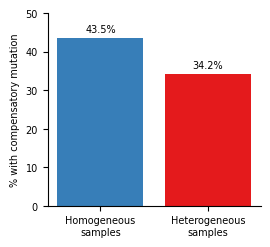

In [29]:
major_samples = samples[(~samples.HAS_MINOR_RAV) & (samples.HAS_MAJOR_RAV)]
minor_samples = samples[(samples.HAS_MINOR_RAV) & (~samples.HAS_MAJOR_RAV)]

major_prop_CM = (major_samples.HAS_COMPENSATORY_MUTATION & major_samples.MAX_CM_FRS>=0.05).sum()/len(major_samples)
minor_prop_CM = (minor_samples.HAS_COMPENSATORY_MUTATION & minor_samples.MAX_CM_FRS>=0.05).sum()/len(minor_samples)

plot_compensation_barplot(major_prop_CM, minor_prop_CM, save_name='bar-compensatory-frs', save_figure=True)

In [30]:
samples_copy = copy.deepcopy(samples)
samples_copy = samples_copy[~(samples_copy['HAS_MINOR_RAV'] & samples_copy['HAS_MAJOR_RAV'])]
samples_copy = samples_copy[~(~(samples_copy['HAS_MINOR_RAV']) & ~(samples_copy['HAS_MAJOR_RAV']))]
samples_copy['FRS_CM'] = (samples_copy['HAS_COMPENSATORY_MUTATION']) #& (samples_copy['MAX_CM_FRS'] > 0.05)

contingency = pd.crosstab(samples_copy.HAS_MINOR_RAV,samples_copy.FRS_CM)
print(contingency)

odds_ratio, p_value = fisher_exact(contingency)
print("The fishers exact p-value for the association of CMs with the sample type homogenous vs heterogeneous is {:.2e}".format(p_value))

FRS_CM         False  True 
HAS_MINOR_RAV              
False           7646   5887
True             244    127
The fishers exact p-value for the association of CMs with the sample type homogenous vs heterogeneous is 3.63e-04


In [31]:
minor_samples_with_CM = minor_samples[minor_samples.HAS_COMPENSATORY_MUTATION & (minor_samples.MAX_CM_FRS<0.9)]
print(f"There are {len(minor_samples_with_CM)} minor RAV samples with a minor compensatory mutation")

There are 104 minor RAV samples with a minor compensatory mutation


If we are to look at the correlation between the FRS for the RAVs and CMs, we need to exclude any samples with multiple mutations as these are likely to be more complex mixtures.

In [32]:
pd.crosstab(minor_samples_with_CM.N_RAV, minor_samples_with_CM.N_CM)

N_CM,1.0,2.0
N_RAV,,
1.0,79,1
2.0,20,3
3.0,1,0


Pearson correlation coefficient: 0.8437
P-value: 1.6870e-22


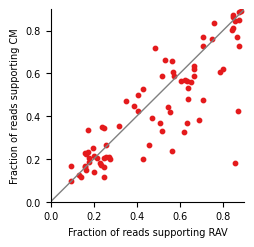

In [33]:
df = minor_samples_with_CM[(minor_samples_with_CM.N_RAV==1) & (minor_samples_with_CM.N_CM==1)]

import scipy.stats as stats

# Calculate Pearson correlation coefficient and p-value
corr_coeff, p_value = stats.pearsonr(df['MAX_RAV_FRS'], df['MAX_CM_FRS'])

# Print the results
print(f"Pearson correlation coefficient: {corr_coeff:.4f}")
print(f"P-value: {p_value:.4e}")

axis = df.plot('MAX_RAV_FRS', 'MAX_CM_FRS', kind='scatter', color='#e41a1c', s=10, figsize=(2.5,2.5))
figure = axis.get_figure()
axis.plot([0, 0.9], [0, 0.9], color='grey', lw=1)
axis.set_xlim(0,0.9)
axis.set_ylim(0,0.9)
axis.set_xticks(np.arange(0,0.9,0.2))
axis.set_yticks(np.arange(0,0.9,0.2))
axis.set_xlabel('Fraction of reads supporting RAV')
axis.set_ylabel('Fraction of reads supporting CM')

# Calculate the line of best fit
slope, intercept = np.polyfit(df['MAX_RAV_FRS'], df['MAX_CM_FRS'], 1)  # Linear regression
line_x = np.linspace(df['MAX_RAV_FRS'].min(), df['MAX_RAV_FRS'].max(), 100)
line_y = slope * line_x + intercept

# Plot the regression line
# plt.plot(line_x, line_y, color='blue', linewidth=1, label=f"y = {slope:.2f}x + {intercept:.2f}")

# remove unnecessary spines
axis.spines["top"].set_visible(False)
axis.spines["right"].set_visible(False)

figure.savefig('pdf/fig-cm-rav-fraction-reads.pdf', bbox_inches='tight', transparent=True)

## Genetic variation in heterogeneous samples with resistant subpopulations

Look at genetic variation to get insight into source of resistance (within-host evolution or secondary infection)

In [34]:
res_minor_uniqueids = samples[(samples['HAS_MINOR_RAV']) & (~samples['HAS_MAJOR_RAV'])].index
print(len(res_minor_uniqueids), 'samples show at least one RAV in a subpopulation and no RAV in over 90 % of the population')

371 samples show at least one RAV in a subpopulation and no RAV in over 90 % of the population


We need to inspect these 371 samples to check if there is more than one RAV per sample with a resistant subpopulation.

In [35]:
effects_subset = effects[effects.UNIQUEID.isin(res_minor_uniqueids)]
summary_rif = effects_subset[['UNIQUEID', 'MUTATION']].groupby('UNIQUEID').count()
summary_rif.MUTATION.value_counts()

MUTATION
1    248
2     95
3     13
4      1
Name: count, dtype: int64

We see some samples with more than one RIV RAF at < 0.90 FRS. We will only look at the samples which have exactly one minor RIF RAV, otherwise we will not know if both of these mutations are in the same subpopulation

In [36]:
solo_rif = summary_rif[summary_rif.MUTATION==1]
solo_rif_effects = effects[effects.UNIQUEID.isin(solo_rif.index)]
solo_rif_effects['MUTATION'] = solo_rif_effects['MUTATION'].str.replace(r':.*', '', regex=True)
solo_rif_effects.set_index(['UNIQUEID','MUTATION'], inplace=True)
solo_rif_effects.index[:3]

#save the solo_rif_effects to csv for later to subset down our mutations table
solo_rif_effects.to_csv('data/cryptic_3/solo_rif_effects.csv')

/var/folders/_3/8y_dwngx2614_y_52fzh1c4w0000gn/T/ipykernel_49782/285981622.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solo_rif_effects['MUTATION'] = solo_rif_effects['MUTATION'].str.replace(r':.*', '', regex=True)


Now we need to reload the mutations table since we had it filtered to only RNAP mutations. This new `mutations` table contains all mutations called in the 248 samples with one RIF RAV at < 0.90 FRS. We ignore mutations that are RIF mutations themselves.

In [37]:
mutations = pd.read_parquet('data/cryptic_3/RES_MINOR_MUTATIONS.parquet', engine='pyarrow')

mutations['GENE_MUTATION'] = np.where(
    mutations['IS_MINOR'],  # Condition: if IS_MINOR_ALLELE is True
    mutations['GENE'].astype(str) + '_' + mutations['MINOR_MUTATION'].astype(str),  # Then: use GENE + MINOR_MUTATION
    mutations['GENE'].astype(str) + '_' + mutations['MUTATION'].astype(str)  # Else: use GENE + MUTATION
)

mutations.set_index(['UNIQUEID','MINOR_MUTATION'], inplace=True)

solo_rif_mutations = mutations[mutations.index.isin(solo_rif_effects.index)]
solo_rif_mutations.reset_index(inplace=True)
solo_rif_mutations.set_index(['UNIQUEID','GENE','GENE_POSITION'], inplace=True)
solo_rif_mutations

mutations.reset_index(inplace=True)
solo_mutations = mutations[mutations.UNIQUEID.isin(solo_rif.index)]
solo_mutations.set_index(['UNIQUEID','GENE','GENE_POSITION'],inplace=True)

# don't forget to ignore the solo rif mutations themselves
solo_other_mutations = solo_mutations[~solo_mutations.index.isin(solo_rif_mutations.index)]
solo_other_mutations

MINOR_MUTATION  \
UNIQUEID                                           GENE   GENE_POSITION                  
site.10.subj.NG00204540.lab.NG00204540.iso.1       PE1     485.0                   NaN   
                                                   PE14    106.0                   NaN   
                                                   PE16    96.0                    NaN   
                                                   PE23    282.0                   NaN   
                                                           344.0                   NaN   
...                                                                                ...   
site.07.subj.106F8637-1A3D-4BFC-BE5F-9040A87A58... vapC47  46.0                    NaN   
                                                   whiB6  -75.0                    NaN   
                                                   yrbE2A  111.0                   NaN   
                                                           160.0                   NaN   
                                                   zwf1   -14.0                    NaN   

                                                                          MUTATION  \
UNIQUEID                                           GENE   GENE_POSITION              
site.10.subj.NG00204540.lab.NG00204540.iso.1       PE1     485.0             L485L   
                                                   PE14    106.0             A106A   
                                                   PE16    96.0               A96A   
                                                   PE23    282.0             S282R   
                                                           344.0             A344T   
...                                                                            ...   
site.07.subj.106F8637-1A3D-4BFC-BE5F-9040A87A58... vapC47  46.0               S46L   
                                                   whiB6  -75.0          -75_del_g   
                                                   yrbE2A  111.0             A111A   
                                                           160.0             L160L   
                                                   zwf1   -14.0              c-14t   

                                                                         REF  \
UNIQUEID                                           GENE   GENE_POSITION        
site.10.subj.NG00204540.lab.NG00204540.iso.1       PE1     485.0         ctg   
                                                   PE14    106.0         gca   
                                                   PE16    96.0          gcg   
                                                   PE23    282.0         agt   
                                                           344.0         gcc   
...                                                                      ...   
site.07.subj.106F8637-1A3D-4BFC-BE5F-9040A87A58... vapC47  46.0          tcg   
                                                   whiB6  -75.0          NaN   
                                                   yrbE2A  111.0         gcc   
                                                           160.0         ctt   
                                                   zwf1   -14.0            c   

                                                                          ALT  \
UNIQUEID                                           GENE   GENE_POSITION         
site.10.subj.NG00204540.lab.NG00204540.iso.1       PE1     485.0          ttg   
                                                   PE14    106.0          gcc   
                                                   PE16    96.0           gct   
                                                   PE23    282.0          agg   
                                                           344.0          acc   
...                                                                       ...   
site.07.subj.106F8637-1A3D-4BFC-BE5F-9040A87A58... vapC47  46.0           ttg   
            

We now count the number of minor mutations in each of the 248 samples with one RIF RAV <90% FRS

In [38]:
#here we need to ignore any null calls, any non minor calls and we set a threshold based on `COV` 
solo_other_variants = solo_other_mutations[(solo_other_mutations.IS_MINOR) & (~solo_other_mutations.IS_NULL) & (solo_other_mutations.COVERAGE>5) & (solo_other_mutations.FRS<0.9)]
solo_other_variants

MINOR_MUTATION  \
UNIQUEID                                           GENE      GENE_POSITION                  
site.10.subj.NG00204540.lab.NG00204540.iso.1       PE_PGRS10 362.0                  I362L   
                                                             364.0                  G364G   
                                                             365.0                  T365L   
                                                             366.0                  G366G   
                                                             368.0                  V368Q   
...                                                                                   ...   
site.07.subj.106F8637-1A3D-4BFC-BE5F-9040A87A58... dop       7.0                      P7R   
                                                   esxL      8.0                      G8G   
                                                             13.0                    H13H   
                                                             37.0                    T37A   
                                                             39.0                    S39G   

                                                                           MUTATION  \
UNIQUEID                                           GENE      GENE_POSITION            
site.10.subj.NG00204540.lab.NG00204540.iso.1       PE_PGRS10 362.0            I362Z   
                                                             364.0            G364Z   
                                                             365.0            T365Z   
                                                             366.0            G366Z   
                                                             368.0            V368Z   
...                                                                             ...   
site.07.subj.106F8637-1A3D-4BFC-BE5F-9040A87A58... dop       7.0                P7Z   
                                                   esxL      8.0                G8Z   
                                                             13.0              H13Z   
                                                             37.0              T37Z   
                                                             39.0              S39Z   

                                                                            REF  \
UNIQUEID                                           GENE      GENE_POSITION        
site.10.subj.NG00204540.lab.NG00204540.iso.1       PE_PGRS10 362.0          atc   
                                                             364.0          ggt   
                                                             365.0          acc   
                                                             366.0          ggg   
                                                             368.0          gtg   
...                                                                         ...   
site.07.subj.106F8637-1A3D-4BFC-BE5F-9040A87A58... dop       7.0            cct   
                                                   esxL      8.0            ggg   
                                                             13.0           cac   
                                                             37.0           acc   
                                                             39.0           agt   

                                                                            ALT  \
UNIQUEID                                           GENE      GENE_POSITION        
site.10.subj.NG00204540.lab.NG00204540.iso.1       PE_PGRS10 362.0          ctc   
                                                             364.0          ggc   
                                                             365.0          ctc   
                                                             366.0          ggc   
                                                             368.0          cag   
...                                                                     

In [39]:
solo_other_variants.reset_index(inplace=True)
solo_other_variants_count = solo_other_variants[['UNIQUEID','GENE_POSITION']].groupby('UNIQUEID').count()
solo_other_variants_count.rename(columns={'GENE_POSITION':'MINOR_COUNT'}, inplace=True)
solo_other_variants_count

,MINOR_COUNT
UNIQUEID,
site.00.subj.1473471.lab.H140800280.iso.1,86
site.00.subj.1473471.lab.H142100097.iso.1,80
site.00.subj.ES_FE21.lab.FE21.iso.1,82
site.00.subj.NETHERLANDS_NLA000301359.lab.NLA000301359.iso.1,70
site.01.subj.DR0182.lab.DR0182.iso.1,1124
...,...
site.ENA.subj.SAMN03648068.lab.1.iso.1,185
site.ENA.subj.SAMN03648752.lab.1.iso.1,103
site.ENA.subj.SAMN03648842.lab.1.iso.1,43


Now we join the table containing the count of minor mutations per sample to a table reporting the RIF mutations in the 248 samples

In [40]:
solo_rif_variants = solo_mutations[solo_mutations.index.isin(solo_rif_mutations.index)]
solo_rif_variants

variant_count_all = solo_rif_variants.join(solo_other_variants_count)
variant_count_all.MINOR_COUNT.fillna(0, inplace=True)
variant_count_all

/var/folders/_3/8y_dwngx2614_y_52fzh1c4w0000gn/T/ipykernel_49782/1204513209.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  variant_count_all.MINOR_COUNT.fillna(0, inplace=True)


,,,MINOR_MUTATION,MUTATION,REF,ALT,NUCLEOTIDE_NUMBER,NUCLEOTIDE_INDEX,CODES_PROTEIN,INDEL_LENGTH,INDEL_NUCLEOTIDES,AMINO_ACID_NUMBER,AMINO_ACID_SEQUENCE,NUMBER_NUCLEOTIDE_CHANGES,IS_NULL,IS_MINOR,MINOR_READS,GENE_MUTATION_POSITION,COVERAGE,FRS,GENE_MUTATION,MINOR_COUNT
UNIQUEID,GENE,GENE_POSITION,,,,,,,,,,,,,,,,,,,,
site.10.subj.NG00204540.lab.NG00204540.iso.1,rpoB,430.0,L430P,L430Z,ctg,ccg,NaN,NaN,True,NaN,None,430.0,P,1.0,False,True,18.0,rpoB_430.0,50.0,0.360000,rpoB_L430P,127
site.05.subj.LR-2502.lab.FN-01440-17.iso.1,rpoB,450.0,S450L,S450Z,tcg,ttg,NaN,NaN,True,NaN,None,450.0,L,1.0,False,True,30.0,rpoB_450.0,47.0,0.638298,rpoB_S450L,967
site.02.subj.0431.lab.235049-14.iso.1,rpoB,430.0,L430P,L430Z,ctg,ccg,NaN,NaN,True,NaN,None,430.0,P,1.0,False,True,10.0,rpoB_430.0,117.0,0.085470,rpoB_L430P,169
site.ENA.subj.SAMEA1403636.lab.1.iso.1,rpoB,450.0,S450L,S450Z,tcg,ttg,NaN,NaN,True,NaN,None,450.0,L,1.0,False,True,40.0,rpoB_450.0,49.0,0.816327,rpoB_S450L,876
site.ENA.subj.SAMN07978245.lab.1.iso.1,rpoB,450.0,S450L,S450Z,tcg,ttg,NaN,NaN,True,NaN,None,450.0,L,1.0,False,True,4.0,rpoB_450.0,5.0,0.800000,rpoB_S450L,866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
site.04.subj.03297.lab.824687.iso.1,rpoB,430.0,L430P,L430Z,ctg,ccg,NaN,NaN,True,NaN,None,430.0,P,1.0,False,True,5.0,rpoB_430.0,18.0,0.277778,rpoB_L430P,2228
site.10.subj.MG03902304.lab.MG03902304.iso.1,rpoB,430.0,L430P,L430Z,ctg,ccg,NaN,NaN,True,NaN,None,430.0,P,1.0,False,True,51.0,rpoB_430.0,57.0,0.894737,rpoB_L430P,69
site.04.subj.03267.lab.824801.iso.1,rpoB,450.0,S450L,S450Z,tcg,ttg,NaN,NaN,True,NaN,None,450.0,L,1.0,False,True,43.0,rpoB_450.0,48.0,0.895833,rpoB_S450L,362


We now plot the distribution of minor mutation counts for all 248 samples with one RIF RAV < 0.90 FRS

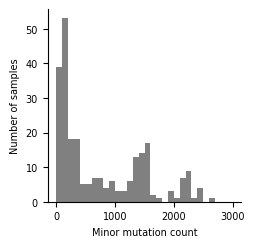

In [41]:
#plot the ditribution of minor alleles in the solo rif samples
fig, ax = plt.subplots(figsize=(2.5,2.5))
variant_count_all.MINOR_COUNT.plot(kind='hist', bins=range(0,3100,100), color='grey', ax=ax)
ax.set_xlabel('Minor mutation count')
ax.set_ylabel('Number of samples')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

fig.savefig('pdf/bar-minor-allele-counts.pdf', bbox_inches='tight', transparent=True)

We can plot the assigned number of (sub)lineages from our pipeline on the distribution. For this, we need to get the corresponding rows from the `genomes` table.

In [41]:
variant_count_all.reset_index(inplace=True)
variant_count_all = variant_count_all.merge(genomes[['N_LINEAGES','SUBLINEAGE']], left_on='UNIQUEID', right_index=True, how='left')
variant_count_all

,UNIQUEID,GENE,GENE_POSITION,MINOR_MUTATION,MUTATION,REF,ALT,NUCLEOTIDE_NUMBER,NUCLEOTIDE_INDEX,CODES_PROTEIN,...,IS_NULL,IS_MINOR,MINOR_READS,GENE_MUTATION_POSITION,COVERAGE,FRS,GENE_MUTATION,MINOR_COUNT,N_LINEAGES,SUBLINEAGE
0,site.10.subj.NG00204540.lab.NG00204540.iso.1,rpoB,430.0,L430P,L430Z,ctg,ccg,NaN,NaN,True,...,False,True,18.0,rpoB_430.0,50.0,0.360000,rpoB_L430P,127,1,lineage2.2.4
1,site.05.subj.LR-2502.lab.FN-01440-17.iso.1,rpoB,450.0,S450L,S450Z,tcg,ttg,NaN,NaN,True,...,False,True,30.0,rpoB_450.0,47.0,0.638298,rpoB_S450L,967,2,lineage4.1.2.1/lineage4.3.3
2,site.02.subj.0431.lab.235049-14.iso.1,rpoB,430.0,L430P,L430Z,ctg,ccg,NaN,NaN,True,...,False,True,10.0,rpoB_430.0,117.0,0.085470,rpoB_L430P,169,1,lineage4.2.2
3,site.ENA.subj.SAMEA1403636.lab.1.iso.1,rpoB,450.0,S450L,S450Z,tcg,ttg,NaN,NaN,True,...,False,True,40.0,rpoB_450.0,49.0,0.816327,rpoB_S450L,876,1,lineage2.2.10
4,site.ENA.subj.SAMN07978245.lab.1.iso.1,rpoB,450.0,S450L,S450Z,tcg,ttg,NaN,NaN,True,...,False,True,4.0,rpoB_450.0,5.0,0.800000,rpoB_S450L,866,1,lineage2.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,site.04.subj.03297.lab.824687.iso.1,rpoB,430.0,L430P,L430Z,ctg,ccg,NaN,NaN,True,...,False,True,5.0,rpoB_430.0,18.0,0.277778,rpoB_L430P,2228,2,lineage1.1.2/lineage4.1.2.1
244,site.10.subj.MG03902304.lab.MG03902304.iso.1,rpoB,430.0,L430P,L430Z,ctg,ccg,NaN,NaN,True,...,False,True,51.0,rpoB_430.0,57.0,0.894737,rpoB_L430P,69,1,lineage2.2.7
245,site.04.subj.03267.lab.824801.iso.1,rpoB,450.0,S450L,S450Z,tcg,ttg,NaN,NaN,True,...,False,True,43.0,rpoB_450.0,48.0,0.895833,rpoB_S450L,362,1,lineage2.2.7
246,site.04.subj.05976.lab.916301.iso.1,rpoB,450.0,S450L,S450Z,tcg,ttg,NaN,NaN,True,...,False,True,3.0,rpoB_450.0,20.0,0.150000,rpoB_S450L,219,1,lineage3.1.2


In [42]:
def extract_main_lineages(sublineage):
    if isinstance(sublineage, str):
        lineages = re.findall(r'lineage(\d+)', sublineage)  # Extract all main lineage numbers
        unique_lineages = sorted(set(lineages))  # Ensure uniqueness and sorted order
        return '+'.join(f'lineage{l}' for l in unique_lineages)  # Format as requested
    return sublineage  # Return unchanged if not a string

variant_count_all['LINEAGES'] = variant_count_all['SUBLINEAGE'].apply(extract_main_lineages)

variant_count_all

,UNIQUEID,GENE,GENE_POSITION,MINOR_MUTATION,MUTATION,REF,ALT,NUCLEOTIDE_NUMBER,NUCLEOTIDE_INDEX,CODES_PROTEIN,...,IS_MINOR,MINOR_READS,GENE_MUTATION_POSITION,COVERAGE,FRS,GENE_MUTATION,MINOR_COUNT,N_LINEAGES,SUBLINEAGE,LINEAGES
0,site.10.subj.NG00204540.lab.NG00204540.iso.1,rpoB,430.0,L430P,L430Z,ctg,ccg,NaN,NaN,True,...,True,18.0,rpoB_430.0,50.0,0.360000,rpoB_L430P,127,1,lineage2.2.4,lineage2
1,site.05.subj.LR-2502.lab.FN-01440-17.iso.1,rpoB,450.0,S450L,S450Z,tcg,ttg,NaN,NaN,True,...,True,30.0,rpoB_450.0,47.0,0.638298,rpoB_S450L,967,2,lineage4.1.2.1/lineage4.3.3,lineage4
2,site.02.subj.0431.lab.235049-14.iso.1,rpoB,430.0,L430P,L430Z,ctg,ccg,NaN,NaN,True,...,True,10.0,rpoB_430.0,117.0,0.085470,rpoB_L430P,169,1,lineage4.2.2,lineage4
3,site.ENA.subj.SAMEA1403636.lab.1.iso.1,rpoB,450.0,S450L,S450Z,tcg,ttg,NaN,NaN,True,...,True,40.0,rpoB_450.0,49.0,0.816327,rpoB_S450L,876,1,lineage2.2.10,lineage2
4,site.ENA.subj.SAMN07978245.lab.1.iso.1,rpoB,450.0,S450L,S450Z,tcg,ttg,NaN,NaN,True,...,True,4.0,rpoB_450.0,5.0,0.800000,rpoB_S450L,866,1,lineage2.1,lineage2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,site.04.subj.03297.lab.824687.iso.1,rpoB,430.0,L430P,L430Z,ctg,ccg,NaN,NaN,True,...,True,5.0,rpoB_430.0,18.0,0.277778,rpoB_L430P,2228,2,lineage1.1.2/lineage4.1.2.1,lineage1+lineage4
244,site.10.subj.MG03902304.lab.MG03902304.iso.1,rpoB,430.0,L430P,L430Z,ctg,ccg,NaN,NaN,True,...,True,51.0,rpoB_430.0,57.0,0.894737,rpoB_L430P,69,1,lineage2.2.7,lineage2
245,site.04.subj.03267.lab.824801.iso.1,rpoB,450.0,S450L,S450Z,tcg,ttg,NaN,NaN,True,...,True,43.0,rpoB_450.0,48.0,0.895833,rpoB_S450L,362,1,lineage2.2.7,lineage2
246,site.04.subj.05976.lab.916301.iso.1,rpoB,450.0,S450L,S450Z,tcg,ttg,NaN,NaN,True,...,True,3.0,rpoB_450.0,20.0,0.150000,rpoB_S450L,219,1,lineage3.1.2,lineage3


In [43]:
#make another column for the mixture type based on columns 'N_LINEAGES' and 'LINEAGES'
variant_count_all['MIXTURE_TYPE'] = np.where(
    (variant_count_all['N_LINEAGES'] > 1) & (~variant_count_all.LINEAGES.str.contains(r'\+', regex=True)), 'sublineages', 
    np.where((variant_count_all['N_LINEAGES'] > 1) & (variant_count_all.LINEAGES.str.contains(r'\+', regex=True)), 'lineages', 'single'))

variant_count_all.MIXTURE_TYPE.value_counts()

MIXTURE_TYPE
single         163
lineages        68
sublineages     17
Name: count, dtype: int64

We join the mykrobe results to our data table containing the number of minor alleles per sample

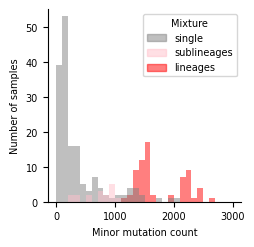

In [44]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(2.5, 2.5))  # Adjust the size as needed

# Define colors for each group
colors = ['red', 'grey', 'pink']

# Group the data by the column with strings
groups = variant_count_all.groupby('MIXTURE_TYPE')

# Define the desired order for the legend
legend_order = ['single', 'sublineages', 'lineages']

# Store proxies for the legend
legend_proxies = {}

# Loop through each group and plot its histogram
for (label, group), color in zip(groups, colors):
    group['MINOR_COUNT'].plot(
        kind='hist',
        bins=range(0, 3100, 100),  # Adjust bin size if necessary
        color=color,
        alpha=0.5,  # Make bars semi-transparent for overlapping
        label=label,
        ax=ax
    )
    # Create a proxy artist for the legend
    if label in legend_order:
        legend_proxies[label] = mpatches.Patch(color=color, alpha=0.5)

# Add the legend with the correct order
ordered_proxies = [legend_proxies[label] for label in legend_order]
ax.legend(ordered_proxies, legend_order, title='Mixture', loc='upper right')

# Add labels and customize appearance
ax.set_ylim(0, 55)
ax.set_yticks(range(0, 60, 10))
ax.set_xlabel('Minor mutation count')
ax.set_ylabel('Number of samples')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

fig.savefig('pdf/bar-lineage-minor-allele-counts.pdf', bbox_inches='tight', transparent=True)

Make a plot showing the difference in minor allele count in samples with and without Lineage 1 in the lineage mixture

In [45]:
unique_lineages = variant_count_all.LINEAGES.unique()

# keep only the sample with two lineages
unique_lineages = [lineage for lineage in unique_lineages if '+' in lineage]

unique_lineages = unique_lineages[:6]
unique_lineages.sort()
unique_lineages

['lineage1+lineage2',
 'lineage1+lineage3',
 'lineage1+lineage4',
 'lineage2+lineage3',
 'lineage2+lineage4',
 'lineage3+lineage4']

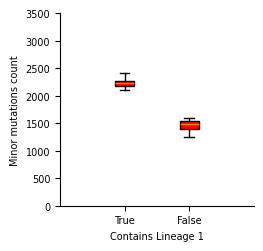

In [46]:
#combine the bins for modern and ancient lineages, respectively
unique_lineages_1 = unique_lineages[:3]
unique_lineages_2 = unique_lineages[-3:]

#make list of lists, where each list is a list of the unique lineages
unique_lineages_combined = [unique_lineages_1, unique_lineages_2]

fig = plt.figure(figsize=(2.5, 2.5))
axes = fig.gca()

for i, lineages in enumerate(unique_lineages_combined):
    tmp = variant_count_all[(variant_count_all.MIXTURE_TYPE == 'lineages') & (variant_count_all.LINEAGES.isin(lineages))]
    axes.boxplot(tmp.MINOR_COUNT, positions=[i], showfliers=False, patch_artist=True, boxprops=dict(facecolor='red'), widths=0.3)

axes.set_xticks(range(len(unique_lineages_combined)))
# axes.set_xticklabels(['+'.join(lineages) for lineages in unique_lineages_combined], rotation=45)
axes.set_xticklabels(['True','False'])
axes.set_xlim(-1, len(unique_lineages_combined))
axes.set_ylim(0, 3500)
axes.set_xlabel('Contains Lineage 1')
axes.set_ylabel('Minor mutations count')
axes.spines[["right", "top"]].set_visible(False)

fig.savefig('pdf/minor_allele_lineage_mix_combined.pdf', bbox_inches='tight', transparent=True)


In [47]:
sum_lin = variant_count_all[(variant_count_all.MIXTURE_TYPE == 'lineages') & (variant_count_all.LINEAGES.isin(unique_lineages[0:2]))].MINOR_COUNT.sum()
count_lin = len(variant_count_all[(variant_count_all.MIXTURE_TYPE == 'lineages') & (variant_count_all.LINEAGES==unique_lineages[0])])
print("The average minor allele count for samples containing Lineage 1 is", round(sum_lin/count_lin,0))

The average minor allele count for samples containing Lineage 1 is 2598.0


In [48]:
sum_lin = variant_count_all[(variant_count_all.MIXTURE_TYPE == 'lineages') & (variant_count_all.LINEAGES.isin(unique_lineages[2:4]))].MINOR_COUNT.sum()
count_lin = len(variant_count_all[(variant_count_all.MIXTURE_TYPE == 'lineages') & (variant_count_all.LINEAGES==unique_lineages[0])])
print("The average minor allele count for samples containing only modern M. tb lineages is", round(sum_lin/count_lin,0))

The average minor allele count for samples containing only modern M. tb lineages is 2240.0


In [49]:
# add CM flag to variant_count_all where mutations has a CM
mutations['HAS_COMPENSATORY_MUTATION'] = mutations['GENE_MUTATION'].isin(compensatory_mutations)
variant_count_all['CM'] = variant_count_all['UNIQUEID'].isin(mutations[mutations.HAS_COMPENSATORY_MUTATION].UNIQUEID)
variant_count_all[variant_count_all['CM']]

,UNIQUEID,GENE,GENE_POSITION,MINOR_MUTATION,MUTATION,REF,ALT,NUCLEOTIDE_NUMBER,NUCLEOTIDE_INDEX,CODES_PROTEIN,...,GENE_MUTATION_POSITION,COVERAGE,FRS,GENE_MUTATION,MINOR_COUNT,N_LINEAGES,SUBLINEAGE,LINEAGES,MIXTURE_TYPE,CM
6,site.04.subj.00574.lab.706414.iso.1,rpoB,450.0,S450L,S450Z,tcg,ttg,NaN,NaN,True,...,rpoB_450.0,53.0,0.509434,rpoB_S450L,2681,2,lineage1.2.2/lineage4.4.1.1,lineage1+lineage4,lineages,True
8,site.08.subj.28TB-D06-009.lab.2849.iso.1,rpoB,450.0,S450L,S450Z,tcg,ttg,NaN,NaN,True,...,rpoB_450.0,11.0,0.454545,rpoB_S450L,2111,2,lineage1.1.1/lineage2.2.7,lineage1+lineage2,lineages,True
9,site.04.subj.05164.lab.928554.iso.1,rpoB,450.0,S450L,S450Z,tcg,ttg,NaN,NaN,True,...,rpoB_450.0,28.0,0.142857,rpoB_S450L,349,1,lineage4.1.2.1,lineage4,single,True
10,site.03.subj.2731-02_LIB9184.lab.2731-02_LIB91...,rpoB,432.0,Q432P,Q432Z,caa,cca,NaN,NaN,True,...,rpoB_432.0,80.0,0.575000,rpoB_Q432P,1497,2,lineage2.2.10/lineage4.1.2.1,lineage2+lineage4,lineages,True
12,site.05.subj.LS-1669.lab.MA-01736-19.iso.1,rpoB,450.0,S450L,S450Z,tcg,ttg,NaN,NaN,True,...,rpoB_450.0,14.0,0.428571,rpoB_S450L,489,1,lineage4.3.2,lineage4,single,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,site.05.subj.LI2174109.lab.14893_2_18.iso.1,rpoB,450.0,S450L,S450Z,tcg,ttg,NaN,NaN,True,...,rpoB_450.0,36.0,0.750000,rpoB_S450L,289,1,lineage4.3.3,lineage4,single,True
235,site.04.subj.06221.lab.943340.iso.1,rpoB,450.0,S450L,S450Z,tcg,ttg,NaN,NaN,True,...,rpoB_450.0,17.0,0.705882,rpoB_S450L,1187,1,lineage2.2.7,lineage2,single,True
237,site.08.subj.BTN_P299_17.lab.BTN_P299_17.iso.1,rpoB,450.0,S450L,S450Z,tcg,ttg,NaN,NaN,True,...,rpoB_450.0,91.0,0.318681,rpoB_S450L,429,1,lineage2.2,lineage2,single,True
238,site.05.subj.LR-2285.lab.FN-00492-18.iso.1,rpoB,450.0,S450L,S450Z,tcg,ttg,NaN,NaN,True,...,rpoB_450.0,53.0,0.849057,rpoB_S450L,732,1,lineage4,lineage4,single,True


In [50]:
contingency = pd.crosstab(variant_count_all.CM, variant_count_all.MIXTURE_TYPE)
contingency['single_sublineages'] = contingency['single'] + contingency['sublineages']
contingency.drop(columns=['single', 'sublineages'], inplace=True)
print(contingency)


MIXTURE_TYPE  lineages  single_sublineages
CM                                        
False               28                 122
True                40                  58


In [51]:
# test for signifcance
odds_ratio, p_value = fisher_exact(contingency)
print("The fishers exact p-value for the association of CMs with the mixture type is {:.2e}".format(p_value))

The fishers exact p-value for the association of CMs with the mixture type is 2.38e-04
